In [2]:
import numpy as np
import cv2
import glob
import os
import math
# threshold <= 10 has better result, 15 has bad result
def Convert_Image(src_img, threshold_i=5):
    gray_img = np.zeros((src_img.shape[0], src_img.shape[1]), dtype=np.uint8)
    mtb_img = np.zeros((src_img.shape[0], src_img.shape[1]), dtype=np.uint8)
    mask_img = np.zeros((src_img.shape[0], src_img.shape[1]), dtype=np.uint8)
    denoise_img = np.zeros((src_img.shape[0], src_img.shape[1]), dtype=np.uint8)

    # convert to grayscale
    temp_img = src_img.astype(np.uint32)    # prevent overflow
    gray_img = (temp_img[:,:,0]*19/256 + temp_img[:,:,1]*183/256 + temp_img[:,:,2]*54/256)     # BGR
    med_i = np.median(gray_img)

    # convert to MTB
    mtb_img = np.where(gray_img > med_i, 255, 0)

    # exclusion map
    upper_bound = med_i + threshold_i
    lower_bound = med_i - threshold_i
    mask_img[gray_img < lower_bound] = 255
    mask_img[gray_img > upper_bound] = 255

    # bind mask_img and mtb_img
    denoise_img = np.logical_and(mtb_img, mask_img)
    
    
    return denoise_img

# shift tar to find current best dx, dy in 9 pixels
def Shift_Image(src, tar, last_dx, last_dy):
    # convert to grayscale first (denoise_img)
    src_dimg = Convert_Image(src)
    tar_dimg = Convert_Image(tar)

    # shift last dx,dy
    h, w = src_dimg.shape[:2]
    min = h * w
    M = np.float32([[1, 0, last_dx*2], [0, 1, last_dy*2]])
    src_dimg = src_dimg.astype(np.uint8)
    tar_dimg = tar_dimg.astype(np.uint8)
    new_tar = cv2.warpAffine(tar_dimg, M, (w, h))

    # then find current best dx, dy
    for x in range(-1,2):
        for y in range(-1,2):
            M = np.float32([[1, 0, x], [0, 1, y]])        # M為平移矩陣,x為寬移動的距離,y為高
            tmp_tar = cv2.warpAffine(new_tar, M, (w, h))  # 仿射變換函式   (w, h):平移後圖像的大小
            z = np.sum(np.logical_xor(src_dimg, tmp_tar) == 1)
            if z < min:
                min = z
                dx = x
                dy = y

    # image * 2, so shift * 2
    return dx + last_dx*2, dy + last_dy*2

# input RGB image src, tar    num = scale 1/2 times
def Image_Alignment(src, tar, num):
    if num == 0:
        dx, dy = Shift_Image(src, tar, 0, 0)
    else:
        h, w = src.shape[:2]
        h_src = cv2.resize(src, (h//2,w//2))
        h_tar = cv2.resize(tar, (h//2,w//2))
        last_dx, last_dy = Image_Alignment(h_src, h_tar, num-1)
        dx, dy = Shift_Image(src, tar, last_dx, last_dy)

    return dx, dy  


# test
# a = cv2.imread('my_data/my_1.jpg')
# b = cv2.imread('my_data/my_2.jpg')

# d_x, d_y = Image_Alignment(a, b, 5)

# print(d_x,d_y)

# h, w = b.shape[:2]
# M = np.float32([[1, 0, d_x], [0, 1, d_y]])    # M為平移矩陣,x為寬移動的距離,y為高
# tmp_tar = cv2.warpAffine(b, M, (w, h))        # 仿射變換函式   (w, h):平移後圖像的大小

# cv2.imwrite(os.path.join('my_output','shift_img.jpg'), tmp_tar)


# main()

# Read file
# imgspath = glob.glob(os.path.join('memorial','*.png'))
imgspath = glob.glob(os.path.join('hdr_pic/house','*.jpg'))
# imgspath = glob.glob(os.path.join('hdr_pic/library','*.jpg'))
imgs = [cv2.imread(i) for i in imgspath]
All_Img = []


source_image = imgs[0]
All_Img.append(source_image)
for i,ele in enumerate(imgs[1:]):
    d_x, d_y = Image_Alignment(source_image, ele, 5)
    print(d_x,d_y)

    h, w = ele.shape[:2]
    M = np.float32([[1, 0, d_x], [0, 1, d_y]])
    after_shift_ele = cv2.warpAffine(ele, M, (w, h)) 
    All_Img.append(after_shift_ele)
    # cv2.imwrite(os.path.join('memorial_output', f'img{i}.png'), after_shift_ele)
    cv2.imwrite(os.path.join('hdr_pic_output/house', f'img{i}.jpg'), after_shift_ele)
    # cv2.imwrite(os.path.join('hdr_pic_output/library', f'img{i}.jpg'), after_shift_ele)


-1 -1
-2 -1
2 -1
-2 -1
-1 -3
-1 -2
2 -3
1 -3


(256, 1)
(256, 1)
(256, 1)


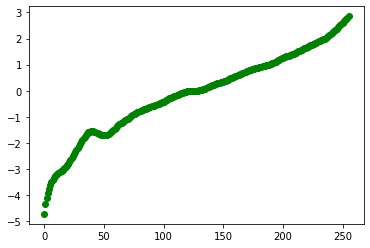

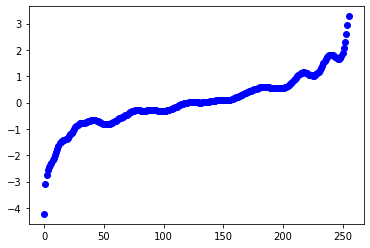

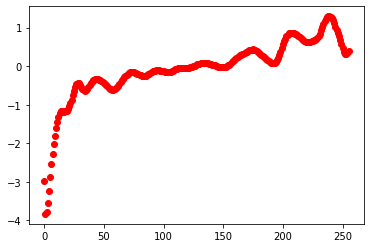

In [22]:
# from scipy.sparse import csr_matrix
import math
import numpy as np
import cv2

N,P = 50,9

matrix_b = np.zeros((N*P+255,1))
matrix_Left_Top = np.zeros((N*P,256))
matrix_Right_Top = np.zeros((N*P,N))
# pic = (np.random.rand(P,1024,768)*255).astype(dtype=np.int32)
pic = All_Img

def weight(zij):
    return zij if zij < 128 else 256 - zij


def solution(pic, color):
    color_map = {
        0:'g',
        1:'b',
        2:'r'
    }
    h,w = imgs[0].shape[:2]
    pointy = (np.random.rand(N)*h).astype(dtype=np.int32)
    pointx = (np.random.rand(N)*w).astype(dtype=np.int32)
    for i in range(N):    
        for j in range(P):
            w = weight(pic[j][pointy[i]][pointx[i]][color]+1)
            # a矩陣 左上 n*p X 256 的矩陣
            matrix_Left_Top[i*P+j][pic[j][pointy[i]][pointx[i]][color]] = w
            # a矩陣 右上 n*p X n 的矩陣
            matrix_Right_Top[i*P+j][i] = -w
            # b矩陣 上半部
            matrix_b[i*P+j] = math.log(np.power((0.5),j+1)) * w


    matrix_Top = np.hstack((matrix_Left_Top,matrix_Right_Top))
    matrix_Middle = np.zeros((1,256+N))
    matrix_Middle[0][127] = 1
    matrix_Up = np.vstack((matrix_Top,matrix_Middle))

    matrix_Bottom = np.zeros((254,256+N))
    for i in range(254):
        matrix_Bottom[i][i] = weight(i+1)
        matrix_Bottom[i][i+1] = -2 * weight(i+1)
        matrix_Bottom[i][i+2] = weight(i+1)

    # matrix a DONE
    matrix_Bottom = matrix_Bottom *20
    matrix_A = np.vstack((matrix_Up,matrix_Bottom))


    solution = np.linalg.lstsq(matrix_A,matrix_b, rcond=None)[0][:256]
    # solution = np.exp(solution)
    # solution = np.asanyarray(solution)

    print(solution.shape)

    import matplotlib.pyplot as plt

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(solution, 'r')
    # print(solution.shape)


    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(solution, f'{color_map[color]}o')
    plt.savefig(f'Response Curse color_map[color].jpg')
    return solution
    
solutions = [solution(pic, i) for i in range(3)]
    


array([-1.70489244])

In [97]:
for j in range(5):
    print(np.power((0.5),j))

1.0
0.5
0.25
0.125
0.0625


In [55]:
N,P=50,10
test = np.zeros((N*P,256))
pic = (np.random.rand(1024,768)*255).astype(dtype=np.int32)
pointx = (np.random.rand(50)*1024).astype(dtype=np.int32)
pointy = (np.random.rand(50)*768).astype(dtype=np.int32)
a = np.concatenate((np.array([pointx]),np.array([pointy])),axis=0)
a.transpose()
test[:50][pic[a[:50]]]=1

SyntaxError: invalid syntax (2274892585.py, line 8)

In [76]:
mat=[1,2,3,4]
may=[5,6,7,8]
np.vstack((mat,may)).shape


(2, 4)

In [51]:
a = np.concatenate((np.array([pointx]),np.array([pointy])),axis=0)
a.transpose()

array([[ 165,   14],
       [ 582,  482],
       [ 454,  657],
       [ 511,  366],
       [ 817,  463],
       [ 278,  390],
       [ 354,  669],
       [ 536,  147],
       [ 845,   25],
       [ 865,  711],
       [ 873,   99],
       [ 193,  115],
       [ 847,  378],
       [ 776,   19],
       [ 688,  430],
       [ 208,  114],
       [ 178,   25],
       [ 957,  244],
       [ 582,  681],
       [ 690,  397],
       [  26,  123],
       [ 499,  301],
       [ 598,  281],
       [ 553,  757],
       [ 583,  550],
       [ 532,  401],
       [ 585,  150],
       [ 699,  556],
       [ 380,  688],
       [1002,  484],
       [ 691,   69],
       [ 942,  410],
       [ 693,  644],
       [ 364,   77],
       [ 291,  755],
       [ 413,  544],
       [   6,   23],
       [ 722,  104],
       [ 145,  590],
       [ 897,  667],
       [ 606,  343],
       [ 104,  580],
       [ 858,  116],
       [ 235,  399],
       [ 596,  386],
       [  32,  161],
       [ 806,  736],
       [ 617,